In [1]:
# Setting up google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [2]:
import my_utils as mu
import torch
from torch import nn
from torch.nn import functional as F

In [3]:
import torchvision
import torchvision.transforms as transforms

## 1. Read Dataset and Create Dataloaders (5%)

This section is about reading the CIFAR-10 dataset. It requires us to download it which is done automatically when this code is run.

The dataloaders are also created. This includes for both the training data and the testing data.

Finally, the classes are defined. There are 10 classes in total which includes: planes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.


The data iterators have also been created to allow the training and classification loops to iterate through the datasets.




In [5]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_iter = iter(trainloader)
test_iter = iter(testloader)

100%|██████████| 170498071/170498071 [00:12<00:00, 13118265.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


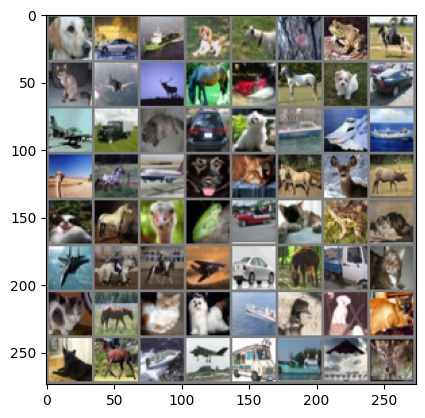

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Create the model (40%)

This section is about creating the model that uses the CIFAR-10 dataset to train and classify.

The components of the model are as follows:


1.   Block: Consists of k-convolutional layers and a single linear layer. The output of the k-convolutional layers are each multiplied by a "part" of the single output of the linear layer. The results are summed and this is the output.
2.   Backbone: Consists of multiple blocks feeding into one another. The output of each block is fed into the next block. Finally, the blocks produce an output, that has been fed through the entire network, that is spatially average pooled and prepared to be used for classification of the 10 classes.



In [7]:
class Block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Block, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(input_channels*32*32, output_channels*8*8*5)

        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.bn4 = nn.BatchNorm2d(output_channels)
        self.bn5 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out1 = self.bn1(F.relu(self.conv1(x)))
        out2 = self.bn2(F.relu(self.conv2(x)))
        out3 = self.bn3(F.relu(self.conv3(x)))
        out4 = self.bn4(F.relu(self.conv4(x)))
        out5 = self.bn5(F.relu(self.conv5(x)))

        pooled = F.adaptive_avg_pool2d(x, output_size=(32, 32))
        pooled_flat = pooled.view(pooled.size(0), -1)
        linear_out = self.fc1(pooled_flat)

        split_linear_out = linear_out.chunk(5, dim=1)
        split_linear_out = [part.view(-1, self.output_channels, 8, 8) for part in split_linear_out]
        split_linear_out = [F.interpolate(part, size=(32, 32), mode='bilinear', align_corners=False) for part in split_linear_out]

        out1 = out1 * split_linear_out[0]
        out2 = out2 * split_linear_out[1]
        out3 = out3 * split_linear_out[2]
        out4 = out4 * split_linear_out[3]
        out5 = out5 * split_linear_out[4]

        out = out1 + out2 + out3 + out4 + out5

        return out

dog   car   ship  dog   dog   bird  frog  horse cat   plane deer  horse car   horse dog   car   plane truck cat   car   dog   ship  ship  ship  bird  horse plane dog   cat   horse deer  deer  dog   horse bird  frog  car   cat   frog  cat   plane horse horse plane car   deer  truck cat   cat   horse cat   dog   ship  bird  dog   cat   dog   horse ship  plane truck ship  plane deer 


In [8]:
#net= Block(3,16)

In [9]:
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.b1 = Block(3, 16)
        self.b2 = Block(16, 32)
        self.b3 = Block(32, 64)
        self.last = nn.Sequential(nn.Flatten(), nn.Linear(64, 10))

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        out = self.b3(out)
        out = F.adaptive_avg_pool2d(out, output_size=(1,1))
        out = self.last(out)
        return out

net = Backbone()

## 3. Create the loss and optimizer (5%)

This section is about creating the loss function and optimizer. It requires selecting a loss function and optimization algorithm.

The loss function algorithm used is CrossEntropyLoss. This includes Softmax Regression that is used for the classification step.

The optimization algorithm used is Stochastic gradient descent (SGD). This is a standard optimization algorithm that I picked as a default option.



In [11]:
lr = 0.01
num_epochs = 20
batch_size = 64

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## 4. Write the training script to train the model (30%)

In [12]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
  net.to(device)
  print(f'Starting training for {num_epochs} epochs')
  for epoch in range(num_epochs):
    print(f'Start of epoch {epoch+1}/{num_epochs}')
    metric = mu.d2l.Accumulator(3)
    for i, (X, y) in enumerate(train_iter):
        net.train()
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        optimizer.step()
        with torch.no_grad():
            metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
        train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
    print(f'End of epoch {epoch+1}: training loss={train_loss:.3f}, training accuracy={train_acc:.3f}, learning rate={optimizer.param_groups[-1]["lr"]:.3f}')
    train_iter = iter(trainloader)
    scheduler.step()
  print('Training complete')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0))
trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device)

Using device: cuda
Tesla T4
Starting training for 20 epochs
Start of epoch 1/20
End of epoch 1: training loss=2.181, training accuracy=0.214, learning rate=0.010
Start of epoch 2/20
End of epoch 2: training loss=1.875, training accuracy=0.363, learning rate=0.010
Start of epoch 3/20
End of epoch 3: training loss=1.579, training accuracy=0.462, learning rate=0.010
Start of epoch 4/20
End of epoch 4: training loss=1.306, training accuracy=0.554, learning rate=0.010
Start of epoch 5/20
End of epoch 5: training loss=1.112, training accuracy=0.623, learning rate=0.010
Start of epoch 6/20
End of epoch 6: training loss=0.859, training accuracy=0.706, learning rate=0.005
Start of epoch 7/20
End of epoch 7: training loss=0.727, training accuracy=0.751, learning rate=0.005
Start of epoch 8/20
End of epoch 8: training loss=0.620, training accuracy=0.789, learning rate=0.005
Start of epoch 9/20
End of epoch 9: training loss=0.526, training accuracy=0.824, learning rate=0.005
Start of epoch 10/20
E

## 5. Final model accuracy on CIFAR-10 Validation Set (20%)

This section is about classifying the images used the model.

The model has been trained now.

Therefore, we can use its learned patterns to classify the CIFAR-10 dataset.


This section includes a classifier which tests the model by classifying images from the dataset.

It then produces an overall accuracy of the network, and finally further optional accuracy scores for each class.

Accuracy of the network on the 10000 test images: 57 %


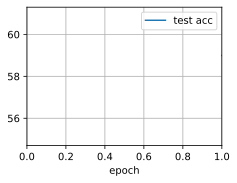

In [14]:
correct = 0
total = 0
test_accuracy_values = []

animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, 1.0], legend=['test acc'])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct // total
        test_accuracy_values.append(test_accuracy)
        animator.add(len(test_accuracy_values), (test_accuracy))

print(f'Accuracy of the network on the 10000 test images: {test_accuracy} %')

In [15]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.1 %
Accuracy for class: car   is 64.8 %
Accuracy for class: bird  is 44.5 %
Accuracy for class: cat   is 38.6 %
Accuracy for class: deer  is 47.7 %
Accuracy for class: dog   is 47.0 %
Accuracy for class: frog  is 69.3 %
Accuracy for class: horse is 61.4 %
Accuracy for class: ship  is 71.2 %
Accuracy for class: truck is 62.9 %
